In [1]:
from generate_mdps import generate_datsets
from dataset import MDPDataset, AllNodeFeatures, InMemoryMDPDataset, TransitionsOnEdge
from experiment import Experiment
from MDP_helpers import calculate_gap, multiclass_recall_score

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import numpy as np

import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import GCN, GAT
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import random_split
from collections import defaultdict
from sklearn.metrics import recall_score

from time import time
from tqdm import tqdm

/home/james/virtual_envs/csiro_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.manual_seed(12345)
np.random.seed(12345)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device='cpu'
print(device)

cuda


In [5]:
# hparam_file = "gat_hparams"
experiment_name = "GAT_NoLR_test_node"

os.mkdir(f"Results/{experiment_name}") if not os.path.isdir(f"Results/{experiment_name}") else ...

In [6]:
N_datasets = 100

N_sites = 5
N_species = 20
K = 7

N_states = 3**N_sites
print(f"N_states: {N_states}")
generate_datsets(N_sites, N_species, K, N_datasets, remove_previous=False, folder="hparam_data")

N_states: 243


'Data already exists'

In [7]:
# dataset = MDPDataset(f"datasets/hparam_data", pre_transform=TransitionsOnEdge())
dataset = InMemoryMDPDataset(f"datasets/hparam_data", pre_transform=AllNodeFeatures())

In [8]:
dataset[0]

Data(x=[243, 1220], edges=[2, 2272], k_labels=[243], P=[5, 243, 243], R=[243, 5], V=[243])

In [9]:
torch.all(dataset[0].R == dataset[5].R)

tensor(False)

In [10]:
train_ratio = 0.8
test_ratio = 0.2

train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_set, test_set = random_split(dataset, [train_size, test_size])

train_data = DataLoader(train_set, batch_size=1, shuffle=True)
test_data = DataLoader(test_set, batch_size=1, shuffle=True)

In [11]:
N_epochs = 1000

def objective(trial):
    hidden_channels = trial.suggest_int("hidden_channels", 50, 300)
    num_layers = trial.suggest_int("num_layers", 1, 5)
    dropout = trial.suggest_float("dropout", 1e-4, 1)
    lr = trial.suggest_float("lr", 1e-6, 0.01)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1)

    gnn_model = GAT(
        in_channels=dataset[0].x.shape[1],
        out_channels=K,
        hidden_channels=hidden_channels,
        num_layers=num_layers,
        dropout=dropout,
    ).to(device)


    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_function = torch.nn.CrossEntropyLoss()

    gnn_model.train()
    old_loss = 0
    count = 0
    for epoch in range(N_epochs):
        optimizer.zero_grad()     
        loss = 0
        for data in train_data:
            pred = gnn_model(
                x = data.x.to(device), 
                edge_index=data.edges.to(device), 
                # edge_attr=data.edge_features.to(device)
            )
            loss += loss_function(pred, data.k_labels.to(device))
            
        loss.backward()
        optimizer.step()

        if torch.abs(old_loss - loss) < 1e-6:
            count += 1
            if count > 100:
                break
        else:
            count = 0
    
    gnn_model.eval()
    # errors = []
    # recall = []
    test_loss = 0
    for data in test_data:
        out = gnn_model(
                x = data.x.to(device), 
                edge_index=data.edges.to(device), 
                # edge_attr=data.edge_features.to(device)
            )
        # pred = F.softmax(out, dim=1).argmax(axis=1)#.to('cpu')

        test_loss += loss_function(pred, data.k_labels.to(device))
    test_loss /= len(test_data)
        # _, error = calculate_gap(data.P, data.R, data.V, pred, K, device=device)
        # errors.append(error.to('cpu'))
        # recall.append(
        #     recall_score(data.k_labels.to('cpu'), pred.to('cpu'), average="macro")
        # )
    
    return test_loss#np.mean(recall) - np.mean(errors) # Minimise errors while maximising recall score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, n_jobs=1)

best_params = study.best_params

print(study.best_value)
print(best_params)

[I 2023-11-19 21:20:53,176] A new study created in memory with name: no-name-46b8f8fc-cdbd-40fe-a1f0-1cfa7dee484e


[I 2023-11-19 21:23:41,987] Trial 0 finished with value: 1.7059049606323242 and parameters: {'hidden_channels': 54, 'num_layers': 3, 'dropout': 0.8969569908999692, 'lr': 0.006275465805422023, 'weight_decay': 0.4063336994633067}. Best is trial 0 with value: 1.7059049606323242.
[I 2023-11-19 21:25:53,090] Trial 1 finished with value: 0.9997822642326355 and parameters: {'hidden_channels': 148, 'num_layers': 2, 'dropout': 0.05879570266235654, 'lr': 0.0017120263195034371, 'weight_decay': 0.4300925893452236}. Best is trial 1 with value: 0.9997822642326355.
[I 2023-11-19 21:27:18,377] Trial 2 finished with value: 1.7174780368804932 and parameters: {'hidden_channels': 131, 'num_layers': 1, 'dropout': 0.9891333502269372, 'lr': 0.0014380329497718184, 'weight_decay': 0.831671936129519}. Best is trial 1 with value: 0.9997822642326355.
[I 2023-11-19 21:30:57,509] Trial 3 finished with value: 1.8655662536621094 and parameters: {'hidden_channels': 234, 'num_layers': 4, 'dropout': 0.7550167990882345, 

In [ ]:
experiment = Experiment(savefile=f"Results/{experiment_name}/hparams_1000_loss")

In [ ]:
# trials = [i for i in map(lambda x: dict([("loss", x.values[0]), ("recall", x.values[1]),*(x.params).items()]), study.get_trials())]
# trials = pd.DataFrame(trials)
# trials = trials.sort_values(by='recall', ascending=False)

trials = [i for i in map(lambda x: dict([("score", x.values[0]),*(x.params).items()]), study.get_trials())]
trials = pd.DataFrame(trials)
trials = trials.sort_values(by='score', ascending=False)

for i in trials.index:
    trials.loc[i].to_dict()
    experiment.save(trials.loc[i].to_dict())

In [ ]:
all_trials = pd.DataFrame(experiment.load()).sort_values(by="score", ascending=True)

In [ ]:
all_trials.head()

,score,hidden_channels,num_layers,dropout,lr,weight_decay
29,0.654883,241.0,2.0,0.505646,0.001560,0.030599
28,0.699302,232.0,3.0,0.840947,0.000715,0.024960
27,0.723042,298.0,2.0,0.566630,0.002098,0.136036
26,0.737601,276.0,2.0,0.707962,0.002234,0.157574
25,0.744222,296.0,2.0,0.590686,0.003864,0.164953


Text(0, 0.5, 'score')

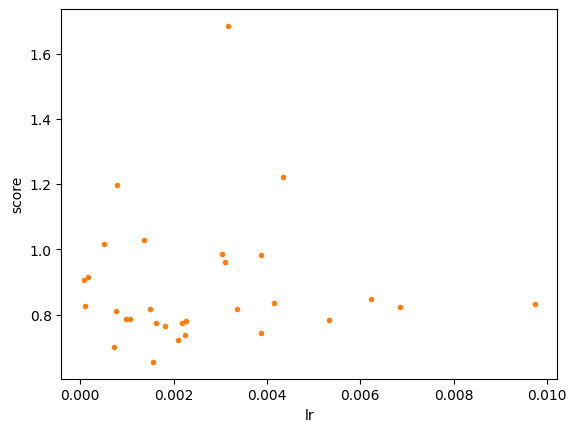

In [ ]:
filt = (all_trials["lr"].between(0.006, 0.1))\
& (all_trials["hidden_channels"].between(132, 141)) \
& (all_trials["dropout"].between(0, 0.2)) \
& (all_trials["weight_decay"].between(0, 0.3)) \




x="lr"
y="score"

plt.scatter(all_trials.loc[filt, x], all_trials.loc[filt, y], marker=".")
plt.scatter(all_trials.loc[~filt, x], all_trials.loc[~filt, y], marker=".")
plt.xlabel(x)
plt.ylabel(y)

In [ ]:
0.009*0.9**30

0.0003815204244769461

In [ ]:
!python3 train_models.py

Traceback (most recent call last):
  File "/home/james/Repo/MDP-State-Abstraction-CSIRO/Approach_new/gcn_model_multi/train_models.py", line 59, in <module>
    raise Exception("Hparams do not yet exist!")
Exception: Hparams do not yet exist!
